# Convolutional neural network for 1 second samples

## Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import tensorflow.keras as keras
import tensorflow as tf
import json
import random
from sklearn.utils import shuffle
from itertools import product
from IPython.display import clear_output 


from google.colab import drive
import glob

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


## Reading data

### Mounting Google Drive

In [4]:
# Mounting drive
drive.mount('/content/drive')
# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/motor_noise_classifier/preprocessed_data"

Mounted at /content/drive
melSpec_data_1sec.json		      segments25sec.csv
melSpec_data_2sec.json		      segments2sec.csv
melSpec_data_5sec.json		      segments2sec_overlap.csv
segments1sec.csv		      segments2sec_overlap_newLabels.csv
segments1sec_overlap.csv	      segments5sec.csv
segments1sec_overlap_newLabels11.csv  segments5sec_overlap.csv
segments1sec_overlap_newLabels.csv    segments5sec_overlap_newLabels.csv


### Reading data from Google Drive

In [5]:
# copying audio data from Google drive
!mkdir preprocessed_data
!cd preprocessed_data
!cp -r '/content/drive/My Drive/motor_noise_classifier/preprocessed_data/melSpec_data_1sec.json' preprocessed_data/melSpec_data.json 
!cp -r '/content/drive/My Drive/motor_noise_classifier/preprocessed_data/segments1sec_overlap_newLabels11.csv' preprocessed_data/segments1sec.csv
!cd .. 

# importing custom functions
!cp -r '/content/drive/My Drive/motor_noise_classifier/my_functions.py' my_functions.py
from my_functions import *

In [6]:
sample_length = 1

# 1 sec samples 
df_src = pd.read_csv("./preprocessed_data/segments1sec.csv", index_col=0)
mel_spec_metadata_file = 'melSpec_data.json'


with open(f'./preprocessed_data/{mel_spec_metadata_file}') as json_file:
    melSpec_data = json.load(json_file)

melSpec_data.keys()

dict_keys(['melSpecShape0', 'melSpecShape1', 'n_fft', 'hop_length'])

## Data preparation - Forming melspectrograms from flat arrays

In [7]:
melSpec_shape = (melSpec_data['melSpecShape0'], melSpec_data['melSpecShape1'])

df = reshapeMelSpecs(df_src, melSpec_shape)
df.sample(5)

(4531, 140, 44)


,motorId,isGood,melSpec
2625,14,False,"[[-20.457450882613568, -20.558040793057927, -2..."
67,1,True,"[[-9.801402837791365, -9.083559115311232, -9.4..."
310,2,True,"[[-16.115297508810727, -14.585283992140909, -1..."
3003,16,False,"[[-7.012558281986866, -6.62645760699688, -9.09..."
3784,20,False,"[[-0.8879534302909082, 0.0, -0.522254402979559..."


## Train-Test Split

The dataset will be split with respect to the motor IDs  
- Test set $\sim 43\%$ - 10 motors
- Train/Validation set $\sim 67\%$  - 13 motors

In [8]:
# load presaved custom shuffled train test split motor list
!cp -r '/content/drive/My Drive/motor_noise_classifier/train_test_shuffled_list.csv' train_test_shuffled_list.csv 
custom_shuffled_list = np.loadtxt('./train_test_shuffled_list.csv')
custom_shuffled_list

array([16., 14., 19.,  7.,  2., 15., 22.,  8., 17., 20., 13., 18., 11.,
       21., 10., 12.,  3.,  5., 23.,  9.,  1.,  6.,  4.])

In [9]:
df_train, df_test, shuffled_list_of_motors = splitTrainTestByMotorId(df, 
                                                                     nb_of_test_motors=10, 
                                                                     custom_shuffled_list=custom_shuffled_list,
                                                                     threshold=0.55,
                                                                     print_results=True
                                                                     )

shuffled_list_of_motors [16. 14. 19.  7.  2. 15. 22.  8. 17. 20. 13. 18. 11. 21. 10. 12.  3.  5.
 23.  9.  1.  6.  4.]
trainSet [13. 18. 11. 21. 10. 12.  3.  5. 23.  9.  1.  6.  4.]
testSet [16. 14. 19.  7.  2. 15. 22.  8. 17. 20.]


In [10]:
# Save the train/test list split for further use
np.savetxt('/content/drive/My Drive/motor_noise_classifier/train_test_shuffled_list.csv', shuffled_list_of_motors, delimiter=',')

## Normalisation with respect to trainset minimum/maximum

In [11]:
## Change to minMaxScaler

train_minimum = np.array(list(df_train.melSpec)).min()
train_maximum = np.array(list(df_train.melSpec)).max()

df_train.melSpec = normalise_dataset(df_train.melSpec, train_minimum, train_maximum)
df_test.melSpec = normalise_dataset(df_test.melSpec, train_minimum, train_maximum)

In [12]:
df_train

,motorId,isGood,melSpec
0,1,True,"[[0.8037009280020257, 0.7987064589514401, 0.73..."
1,1,True,"[[0.8082208866169677, 0.8241121499830566, 0.83..."
2,1,True,"[[0.8362988690836369, 0.8359147877714878, 0.81..."
3,1,True,"[[0.7931875361176519, 0.8102894444013629, 0.77..."
4,1,True,"[[0.7129062323557981, 0.737094645698341, 0.727..."
...,...,...,...
4526,23,False,"[[0.9946696106387369, 1.0, 0.9875084788793369,..."
4527,23,False,"[[0.9944387533908158, 1.0, 0.985900631844029, ..."
4528,23,False,"[[0.9935712020929512, 1.0, 0.9864533497866294,..."
4529,23,False,"[[0.9959703189928698, 1.0, 0.9872190040087113,..."


## Hyperparameters optimization

params:
- CNN archi
- activations
- batch size

In [13]:
callbacks = [keras.callbacks.EarlyStopping(
                 monitor="val_accuracy", 
                 patience=3,
                 verbose=0),             
             ]

### Check different CNN filter numbers

In [14]:
filter_numbers = [ 
                  [16, 32], 
                  [32, 64],
                  [64,128],
                  [128,256],
                  [16, 32, 64],
                  [32, 64, 128],
                  [64, 128, 256],
                  [32, 64, 128, 256],
                  ]
activations = ['relu']
batch_sizes = [64]
dropouts = [None] 

params = pd.DataFrame(list(product(filter_numbers, activations, batch_sizes, dropouts)), 
             columns=['filter_numbers', 'activation', 'batch_size', 'dropouts'])
params

,filter_numbers,activation,batch_size,dropouts
0,"[16, 32]",relu,64,None
1,"[32, 64]",relu,64,None
2,"[64, 128]",relu,64,None
3,"[128, 256]",relu,64,None
4,"[16, 32, 64]",relu,64,None
5,"[32, 64, 128]",relu,64,None
6,"[64, 128, 256]",relu,64,None
7,"[32, 64, 128, 256]",relu,64,None


In [ ]:
grid_search_results = GridSearchCNN(params,
                                    df_train,
                                    k_folds=5,
                                    epochs=20,
                                    callbacks=callbacks,
                                    input_shape=melSpec_shape)

#1/8
fold: #5
accuracies: [1.0, 0.6548223495483398, 1.0, 0.700507640838623, 1.0], mean: 0.8710659980773926
epochs: [5, 3, 1, 2, 2], median: 2.0
#2/8
fold: #5
accuracies: [1.0, 1.0, 1.0, 0.7461928725242615, 1.0], mean: 0.9492385745048523
epochs: [2, 1, 1, 1, 2], median: 1.0
#3/8
fold: #5
accuracies: [1.0, 1.0, 1.0, 0.7512690424919128, 1.0], mean: 0.9502538084983826
epochs: [2, 1, 1, 1, 1], median: 1.0
#4/8
fold: #5
accuracies: [1.0, 1.0, 1.0, 0.7055837512016296, 1.0], mean: 0.9411167502403259
epochs: [3, 1, 1, 1, 1], median: 1.0
#5/8
fold: #5
accuracies: [1.0, 0.5456852912902832, 1.0, 0.6725888252258301, 1.0], mean: 0.8436548233032226
epochs: [2, 1, 1, 4, 3], median: 2.0
#6/8
fold: #5
accuracies: [1.0, 0.7258883118629456, 1.0, 0.6649746298789978, 1.0], mean: 0.8781725883483886
epochs: [3, 2, 1, 4, 2], median: 2.0
#7/8
fold: #5
accuracies: [1.0, 0.5, 1.0, 0.692893385887146, 1.0], mean: 0.8385786771774292
epochs: [2, 1, 1, 2, 1], median: 1.0
#8/8
fold: #5
accuracies: [1.0, 0.7258883118629

In [ ]:
grid_search_results["filter_numbers_str"] = grid_search_results["filter_numbers"]
grid_search_results = grid_search_results.astype({"filter_numbers_str": str})

grid_search_results

,nb_of_layers,filter_numbers,activation,batch_size,dropouts,epochs_nb,accuracy,filter_numbers_str
0,2,"[16, 32]",relu,64,None,2,0.871066,"[16, 32]"
1,2,"[32, 64]",relu,64,None,1,0.949239,"[32, 64]"
2,2,"[64, 128]",relu,64,None,1,0.950254,"[64, 128]"
3,2,"[128, 256]",relu,64,None,1,0.941117,"[128, 256]"
4,3,"[16, 32, 64]",relu,64,None,2,0.843655,"[16, 32, 64]"
5,3,"[32, 64, 128]",relu,64,None,2,0.878173,"[32, 64, 128]"
6,3,"[64, 128, 256]",relu,64,None,1,0.838579,"[64, 128, 256]"
7,4,"[32, 64, 128, 256]",relu,64,None,1,0.881218,"[32, 64, 128, 256]"


<Figure size 432x288 with 0 Axes>

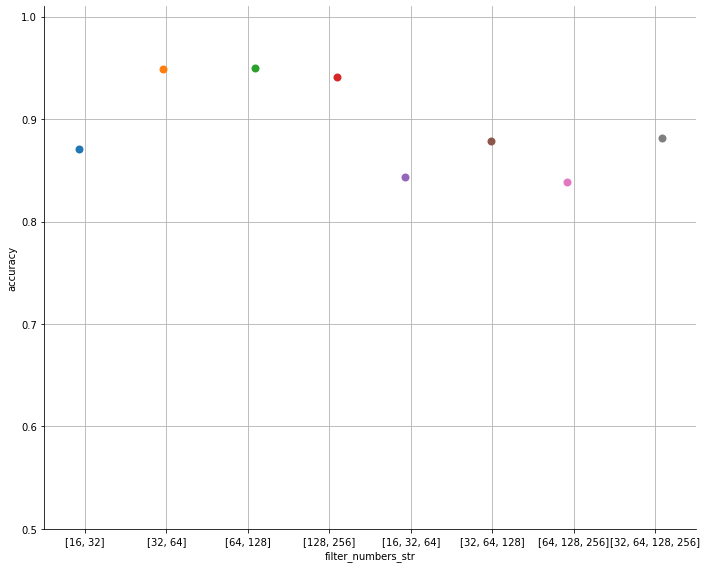

In [ ]:
formGridSearchCatplot(grid_search_results, parameter_to_visualise='filter_numbers_str', ylim=[0.5, 1.01])

The best performance was observed for CNNS with these filter numbers:
- [32, 64]
- [64, 128]
- [128, 256]

These CNNs will be checked for other hyperparameters

### Check batch sizes

In [ ]:
filter_numbers = [ 
                  [32, 64],
                  [64, 128],
                  [128, 256]
                  ]
activations = ['relu']
batch_sizes = [16, 32, 64, 128, 256] 
dropouts = [None] 

params = pd.DataFrame(list(product(filter_numbers, activations, batch_sizes, dropouts)), 
             columns=['filter_numbers', 'activation', 'batch_size', 'dropouts'])
params

,filter_numbers,activation,batch_size,dropouts
0,"[32, 64]",relu,16,None
1,"[32, 64]",relu,32,None
2,"[32, 64]",relu,64,None
3,"[32, 64]",relu,128,None
4,"[32, 64]",relu,256,None
5,"[64, 128]",relu,16,None
6,"[64, 128]",relu,32,None
7,"[64, 128]",relu,64,None
8,"[64, 128]",relu,128,None
9,"[64, 128]",relu,256,None


In [ ]:
grid_search_results = GridSearchCNN(params,
                                    df_train,
                                    k_folds=5,
                                    epochs=20,
                                    callbacks=callbacks,
                                    input_shape=melSpec_shape)

#1/15
fold: #5
accuracies: [0.7182741165161133, 0.7766497731208801, 1.0, 0.5583756566047668, 1.0], mean: 0.8106599092483521
epochs: [2, 1, 1, 4, 1], median: 1.0
#2/15
fold: #5
accuracies: [0.7385786771774292, 1.0, 1.0, 0.6040608882904053, 1.0], mean: 0.8685279130935669
epochs: [15, 1, 3, 1, 1], median: 1.0
#3/15
fold: #5
accuracies: [0.6725888252258301, 0.6751269102096558, 1.0, 1.0, 1.0], mean: 0.8695431470870971
epochs: [2, 15, 2, 1, 2], median: 2.0
#4/15
fold: #5
accuracies: [0.6979695558547974, 0.9949238300323486, 1.0, 1.0, 1.0], mean: 0.9385786771774292
epochs: [4, 4, 2, 2, 3], median: 3.0
#5/15
fold: #5
accuracies: [0.682741105556488, 0.5, 1.0, 1.0, 0.5], mean: 0.7365482211112976
epochs: [7, 4, 1, 1, 1], median: 1.0
#6/15
fold: #5
accuracies: [0.7081218361854553, 0.6040608882904053, 1.0, 0.6116751432418823, 1.0], mean: 0.7847715735435485
epochs: [3, 4, 2, 1, 1], median: 2.0
#7/15
fold: #5
accuracies: [0.720812201499939, 0.7258883118629456, 1.0, 0.6040608882904053, 1.0], mean: 0.81

In [ ]:
grid_search_results

,nb_of_layers,filter_numbers,activation,batch_size,dropouts,epochs_nb,accuracy
0,2,"[32, 64]",relu,16,None,1,0.810660
1,2,"[32, 64]",relu,32,None,1,0.868528
2,2,"[32, 64]",relu,64,None,2,0.869543
3,2,"[32, 64]",relu,128,None,3,0.938579
4,2,"[32, 64]",relu,256,None,1,0.736548
5,2,"[64, 128]",relu,16,None,2,0.784772
6,2,"[64, 128]",relu,32,None,2,0.810152
7,2,"[64, 128]",relu,64,None,1,0.749239
8,2,"[64, 128]",relu,128,None,2,0.946701
9,2,"[64, 128]",relu,256,None,2,0.746193


<Figure size 432x288 with 0 Axes>

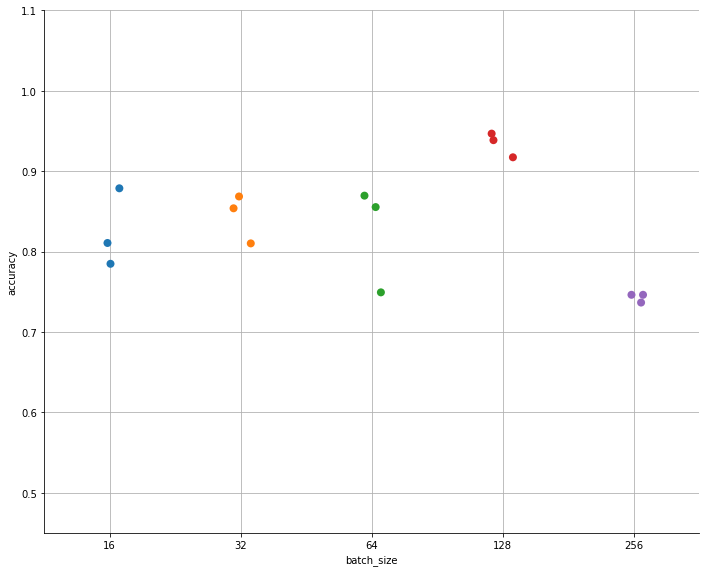

In [ ]:
formGridSearchCatplot(grid_search_results, parameter_to_visualise='batch_size', ylim=[0.45, 1.1])

The best results were obtained for a **batch_size: 128**

<Figure size 432x288 with 0 Axes>

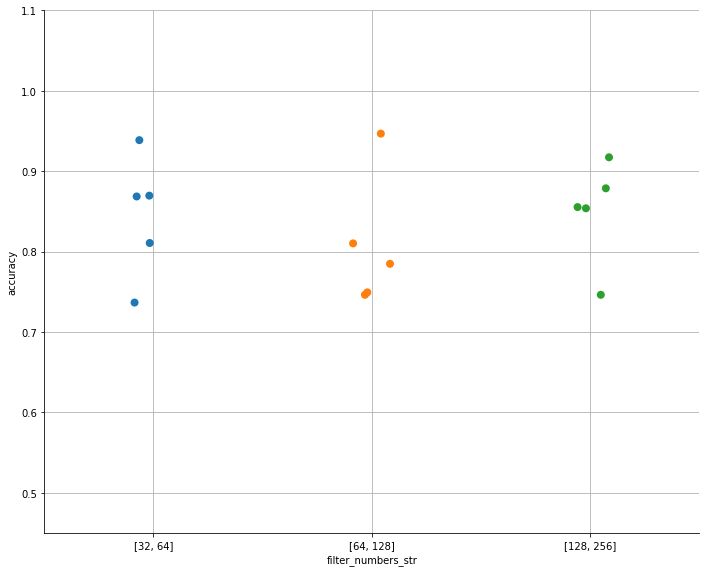

In [ ]:
grid_search_results["filter_numbers_str"] = grid_search_results["filter_numbers"]
grid_search_results = grid_search_results.astype({"filter_numbers_str": str})
formGridSearchCatplot(grid_search_results, parameter_to_visualise='filter_numbers_str', ylim=[0.45, 1.1])

In [ ]:
grid_search_results.groupby("filter_numbers_str").mean()

,accuracy
filter_numbers_str,
"[128, 256]",0.850254
"[32, 64]",0.844772
"[64, 128]",0.807411


### Check activations 

In [ ]:
filter_numbers = [ 
                  [32, 64],
                  [64, 128],
                  [128, 256]
                  ]
activations = ['relu', 'selu']
batch_sizes = [128] 
dropouts = [None] 

params = pd.DataFrame(list(product(filter_numbers, activations, batch_sizes, dropouts)), 
             columns=['filter_numbers', 'activation', 'batch_size', 'dropouts'])
params

,filter_numbers,activation,batch_size,dropouts
0,"[32, 64]",relu,128,None
1,"[32, 64]",selu,128,None
2,"[64, 128]",relu,128,None
3,"[64, 128]",selu,128,None
4,"[128, 256]",relu,128,None
5,"[128, 256]",selu,128,None


In [ ]:
grid_search_results = GridSearchCNN(params,
                                    df_train,
                                    k_folds=5,
                                    epochs=20,
                                    callbacks=callbacks,
                                    input_shape=melSpec_shape)

#1/6
fold: #5
accuracies: [1.0, 1.0, 0.5, 1.0, 0.6979695558547974], mean: 0.8395939111709595
epochs: [1, 5, 1, 2, 4], median: 2.0
#2/6
fold: #5
accuracies: [1.0, 1.0, 0.5, 0.9974619150161743, 0.7461928725242615], mean: 0.8487309575080871
epochs: [1, 6, 1, 1, 3], median: 1.0
#3/6
fold: #5
accuracies: [1.0, 1.0, 0.5, 1.0, 0.7258883118629456], mean: 0.8451776623725891
epochs: [1, 4, 1, 1, 3], median: 1.0
#4/6
fold: #5
accuracies: [1.0, 1.0, 0.8299492597579956, 1.0, 0.703045666217804], mean: 0.9065989851951599
epochs: [1, 6, 12, 1, 9], median: 6.0
#5/6
fold: #5
accuracies: [1.0, 1.0, 0.9416243433952332, 1.0, 0.682741105556488], mean: 0.9248730897903442
epochs: [1, 3, 2, 1, 3], median: 2.0
#6/6
fold: #5
accuracies: [1.0, 1.0, 0.9644669890403748, 1.0, 0.6675127148628235], mean: 0.9263959407806397
epochs: [2, 3, 3, 1, 5], median: 3.0


In [ ]:
grid_search_results

,nb_of_layers,filter_numbers,activation,batch_size,dropouts,epochs_nb,accuracy
0,2,"[32, 64]",relu,128,None,2,0.839594
1,2,"[32, 64]",selu,128,None,1,0.848731
2,2,"[64, 128]",relu,128,None,1,0.845178
3,2,"[64, 128]",selu,128,None,6,0.906599
4,2,"[128, 256]",relu,128,None,2,0.924873
5,2,"[128, 256]",selu,128,None,3,0.926396


<Figure size 432x288 with 0 Axes>

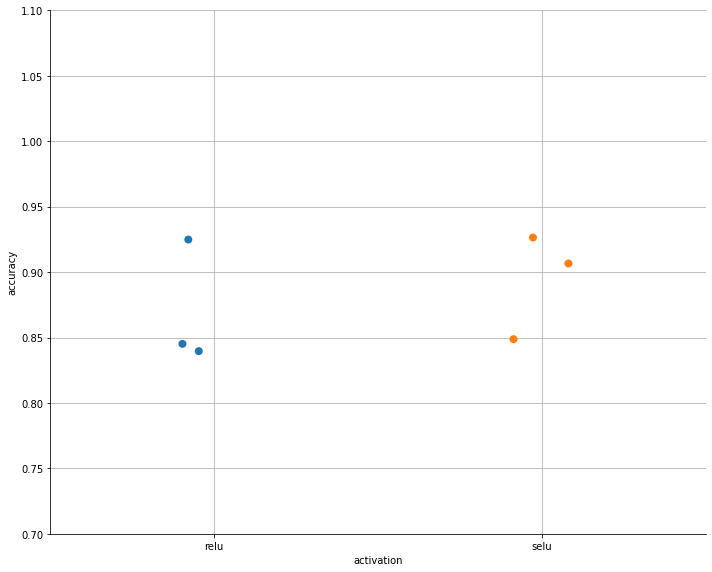

In [ ]:
formGridSearchCatplot(grid_search_results, parameter_to_visualise='activation', ylim=[0.7, 1.1])

In [ ]:
grid_search_results.groupby("activation").mean()

,accuracy
activation,
relu,0.869882
selu,0.893909


Activation function **SeLu** brought slightly better results

<Figure size 432x288 with 0 Axes>

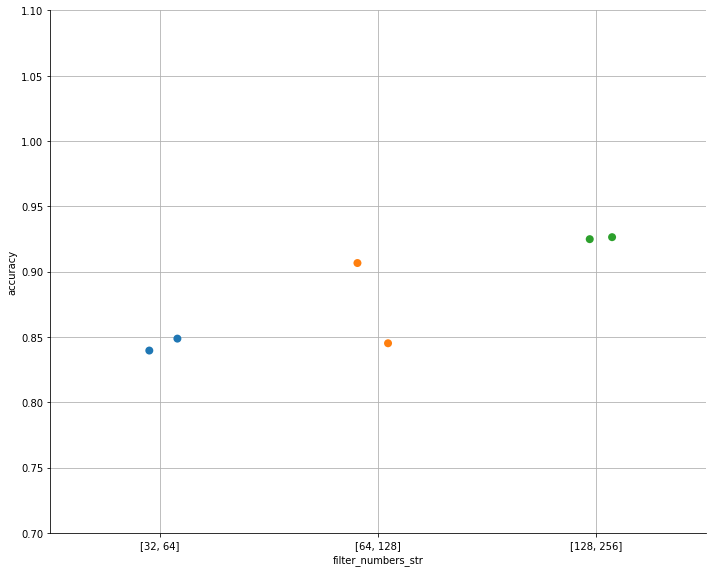

In [ ]:
grid_search_results["filter_numbers_str"] = grid_search_results["filter_numbers"]
grid_search_results = grid_search_results.astype({"filter_numbers_str": str})
formGridSearchCatplot(grid_search_results, parameter_to_visualise='filter_numbers_str', ylim=[0.7, 1.1])

## Final CNN model





In [15]:
samples_good_count = df.isGood.loc[df.isGood==True].count()
samples_bad_count = df.isGood.loc[df.isGood==False].count()

baseline = np.max([samples_good_count, samples_bad_count]) / (samples_good_count + samples_bad_count)
print(f"baseline to beat: {baseline*100 :.2f}%")

baseline to beat: 52.17%


The best parameters found in grid search:
- activation: SeLu
- batch size: 128
- hidden layers structure: [128, 256]

In [16]:
input_submodel = buildCNNInputSubmodel(melSpec_shape)
middle_submodel = buildCNNMiddleSubmodel(nb_of_conv_layers=2,
                                         filter_numbers=[128, 256],
                                         kernel_sizes=[3 for i in range(2)],
                                         activations=['selu' for i in range(2)]
                                         )
output_submodel = Dense(1, activation='sigmoid', name='output')

cnn_clf = buildModel([input_submodel, middle_submodel, output_submodel],
                   loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

cnn_clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_submodel (Sequential)  (None, 140, 44, 1)       0         
                                                                 
 middle_submodel (Sequential  (None, 98560)            296448    
 )                                                               
                                                                 
 output (Dense)              (None, 1)                 98561     
                                                                 
Total params: 395,009
Trainable params: 395,009
Non-trainable params: 0
_________________________________________________________________


In [17]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", 
                                           patience=3, 
                                           verbose=0)
            ]

model_accuracy, epochs_nb, histories = KfoldValidationCNNTraining(cnn_clf, df_train, 
                                                                  k_folds=5, 
                                                                  epochs=30, 
                                                                  batch_size=128, 
                                                                  callbacks=callbacks, 
                                                                  return_histories=True)

fold: #5
accuracies: [1.0, 1.0, 0.9847715497016907, 0.10913705825805664, 0.5], mean: 0.7187817215919494
epochs: [4, 3, 10, 3, 2], median: 3.0


In [18]:
def visualiseTrainingHistories(histories):
    """ Visualises histories of trainings in kFold validation, their loss vs val_loss and accuracy vs val_accuracy
    ---
    args:
        histories:  list of history objects from kValidation trainings
    """
    
    # Defining the subplots
    fig = plt.figure(figsize = (10, 2.5*len(histories)))

    nrows = len(histories)
    ncols = 2
    i = 1

    for fold, history in enumerate(histories):
        accuracy = history.history["accuracy"]
        val_accuracy = history.history["val_accuracy"]
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs = range(1, len(accuracy) + 1)

        # Training
        plt.subplot(nrows, ncols, i)
        plt.plot(epochs, accuracy, "bo-", label="Training accuracy")
        plt.plot(epochs, val_accuracy, "rx-", label="Validation accuracy")
        plt.title(f"Training accuracy, fold #{fold+1}")
        plt.legend()
        i +=1

        # validation
        plt.subplot(nrows, ncols, i)
        plt.plot(epochs, loss, "bo-", label="Training loss")
        plt.plot(epochs, val_loss, "rx-", label="Validation loss")
        plt.title(f"Training loss, fold #{fold+1}")
        plt.legend()
        i +=1

    plt.tight_layout()
    plt.show()

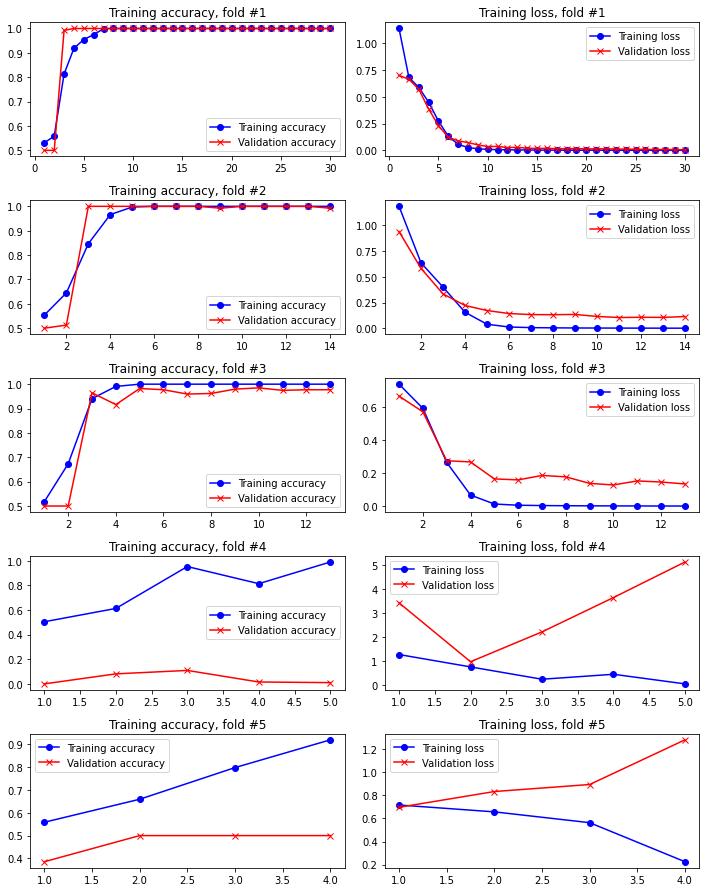

In [19]:
visualiseTrainingHistories(histories)

#### Trying to prevent overfitting with dropout layers

In [37]:
filter_numbers = [[128, 256]]
activations = ['selu']
batch_sizes = [128] 
dropouts = [
            None,
            [0.2, 0.2],
            [0.5, 0.5],
            [0.5, 0.2],
            [0.2, 0.5],
            [0.7, 0.5],
            [0.7, 0.2]
] 

params = pd.DataFrame(list(product(filter_numbers, activations, batch_sizes, dropouts)), 
             columns=['filter_numbers', 'activation', 'batch_size', 'dropouts'])
params

,filter_numbers,activation,batch_size,dropouts
0,"[128, 256]",selu,128,None
1,"[128, 256]",selu,128,"[0.2, 0.2]"
2,"[128, 256]",selu,128,"[0.5, 0.5]"
3,"[128, 256]",selu,128,"[0.5, 0.2]"
4,"[128, 256]",selu,128,"[0.2, 0.5]"
5,"[128, 256]",selu,128,"[0.7, 0.5]"
6,"[128, 256]",selu,128,"[0.7, 0.2]"


In [38]:
callbacks = [keras.callbacks.EarlyStopping(
                 monitor="val_loss", 
                 patience=10,
                 verbose=0),             
             ]

grid_search_results = GridSearchCNN(params,
                                    df_train,
                                    k_folds=5,
                                    epochs=20,
                                    callbacks=callbacks,
                                    input_shape=melSpec_shape)

#1/7
fold: #5
accuracies: [1.0, 0.5, 0.5, 0.5812183022499084, 1.0], mean: 0.7162436604499817
epochs: [7, 1, 1, 6, 3], median: 3.0
#2/7
fold: #5
accuracies: [1.0, 0.5, 0.5, 0.5888324975967407, 0.9974619150161743], mean: 0.717258882522583
epochs: [8, 1, 1, 6, 6], median: 6.0
#3/7
fold: #5
accuracies: [1.0, 0.5, 0.5, 0.5761421322822571, 1.0], mean: 0.7152284264564515
epochs: [8, 1, 1, 5, 8], median: 5.0
#4/7
fold: #5
accuracies: [1.0, 0.5, 0.5, 0.5228426456451416, 0.9847715497016907], mean: 0.7015228390693664
epochs: [10, 1, 1, 6, 16], median: 6.0
#5/7
fold: #5
accuracies: [0.9949238300323486, 0.5, 0.5, 0.5913705825805664, 1.0], mean: 0.717258882522583
epochs: [17, 3, 1, 11, 4], median: 4.0
#6/7
fold: #5
accuracies: [0.9213197827339172, 0.5, 0.6218274235725403, 0.5710659623146057, 0.5888324975967407], mean: 0.6406091332435608
epochs: [17, 1, 3, 5, 18], median: 5.0
#7/7
fold: #5
accuracies: [1.0, 0.5, 0.5, 0.5431472063064575, 1.0], mean: 0.7086294412612915
epochs: [9, 1, 1, 10, 4], median:

In [41]:
grid_search_results["dropouts_str"] = grid_search_results["dropouts"]
grid_search_results = grid_search_results.astype({"dropouts": str})

grid_search_results

,nb_of_layers,filter_numbers,activation,batch_size,dropouts,epochs_nb,accuracy,dropouts_str
0,2,"[128, 256]",selu,128,None,3,0.716244,None
1,2,"[128, 256]",selu,128,"[0.2, 0.2]",6,0.717259,"[0.2, 0.2]"
2,2,"[128, 256]",selu,128,"[0.5, 0.5]",5,0.715228,"[0.5, 0.5]"
3,2,"[128, 256]",selu,128,"[0.5, 0.2]",6,0.701523,"[0.5, 0.2]"
4,2,"[128, 256]",selu,128,"[0.2, 0.5]",4,0.717259,"[0.2, 0.5]"
5,2,"[128, 256]",selu,128,"[0.7, 0.5]",5,0.640609,"[0.7, 0.5]"
6,2,"[128, 256]",selu,128,"[0.7, 0.2]",4,0.708629,"[0.7, 0.2]"


<Figure size 432x288 with 0 Axes>

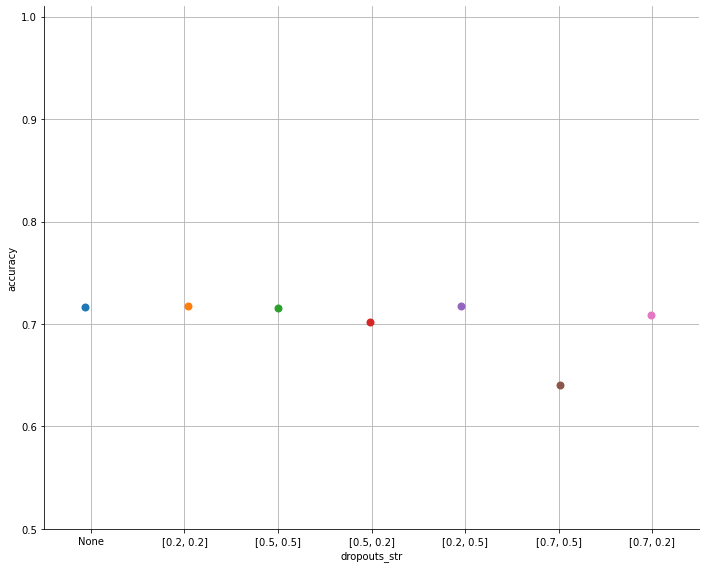

In [42]:
formGridSearchCatplot(grid_search_results, parameter_to_visualise='dropouts_str', ylim=[0.5, 1.01])

We don't really see much improvement when it comes to overfitting while using dropout layers. To see the training history the model with dropouts will be trained on the same splits as the model without dropout layers

##### Dropout - no dropout comparison

List of motor that will be used in both kFoldValidations 

In [53]:
motor_split_list = df_train.motorId.unique() 
random.shuffle(motor_split_list)
print(motor_split_list)

[ 3 23  1 10 13 11 18  5 21  6  9  4 12]



###### Best Model with dropout layers

In [54]:
input_submodel = buildCNNInputSubmodel(melSpec_shape)
middle_submodel = buildCNNMiddleSubmodel(nb_of_conv_layers=2,
                                         filter_numbers=[64, 128],
                                         kernel_sizes=[3 for i in range(2)],
                                         activations=['selu' for i in range(2)],
                                         dropouts=[0.2, 0.5]
                                         )
output_submodel = Dense(1, activation='sigmoid', name='output')

cnn_clf_dropouts = buildModel([input_submodel, middle_submodel, output_submodel],
                              loss='binary_crossentropy',
                              optimizer='adam',
                              metrics=['accuracy'])

cnn_clf_dropouts.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_submodel (Sequential)  (None, 140, 44, 1)       0         
                                                                 
 middle_submodel (Sequential  (None, 49280)            74496     
 )                                                               
                                                                 
 output (Dense)              (None, 1)                 49281     
                                                                 
Total params: 123,777
Trainable params: 123,777
Non-trainable params: 0
_________________________________________________________________


In [55]:
callbacks = [
             keras.callbacks.EarlyStopping(monitor="val_loss", 
                                           patience=10, 
                                           verbose=0)
            ]

model_accuracy, epochs_nb, histories_dropouts = KfoldValidationCNNTraining(cnn_clf_dropouts, 
                                                                            df_train, 
                                                                            k_folds=5, 
                                                                            epochs=20, 
                                                                            batch_size=64, 
                                                                            callbacks=callbacks,
                                                                            shuffled_motor_list=motor_split_list,
                                                                            return_histories=True)

fold: #5
accuracies: [1.0, 1.0, 1.0, 0.989847719669342, 0.6269035339355469], mean: 0.9233502507209778
epochs: [5, 2, 1, 2, 9], median: 2.0


###### Model without dropout layers

In [57]:
input_submodel = buildCNNInputSubmodel(melSpec_shape)
middle_submodel = buildCNNMiddleSubmodel(nb_of_conv_layers=2,
                                         filter_numbers=[64, 128],
                                         kernel_sizes=[3 for i in range(2)],
                                         activations=['selu' for i in range(2)],
                                         dropouts=None
                                         )
output_submodel = Dense(1, activation='sigmoid', name='output')

cnn_clf_no_dropouts = buildModel([input_submodel, middle_submodel, output_submodel],
                              loss='binary_crossentropy',
                              optimizer='adam',
                              metrics=['accuracy'])

cnn_clf_no_dropouts.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_submodel (Sequential)  (None, 140, 44, 1)       0         
                                                                 
 middle_submodel (Sequential  (None, 49280)            74496     
 )                                                               
                                                                 
 output (Dense)              (None, 1)                 49281     
                                                                 
Total params: 123,777
Trainable params: 123,777
Non-trainable params: 0
_________________________________________________________________


In [58]:
model_accuracy, epochs_nb, histories_no_dropouts = KfoldValidationCNNTraining(cnn_clf_no_dropouts, 
                                                                            df_train, 
                                                                            k_folds=5, 
                                                                            epochs=20, 
                                                                            batch_size=64, 
                                                                            callbacks=callbacks,
                                                                            shuffled_motor_list=motor_split_list,
                                                                            return_histories=True)

fold: #5
accuracies: [1.0, 1.0, 0.989847719669342, 0.9720812439918518, 0.6192893385887146], mean: 0.9162436604499817
epochs: [6, 1, 2, 1, 3], median: 2.0


###### History visualisation

**No Dropout layers**


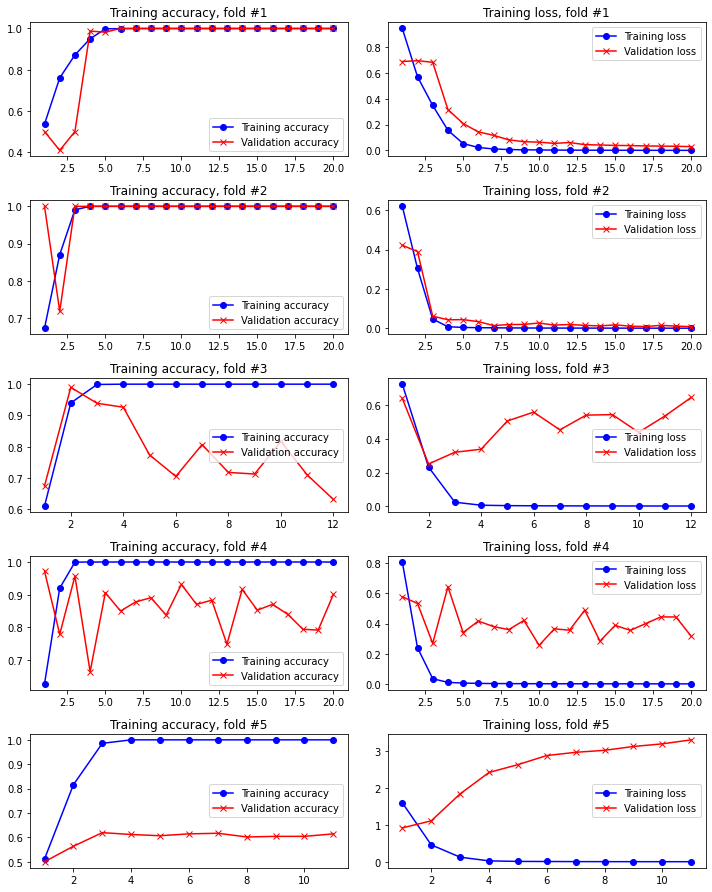

In [59]:
visualiseTrainingHistories(histories_no_dropouts)

**With dropout layers**

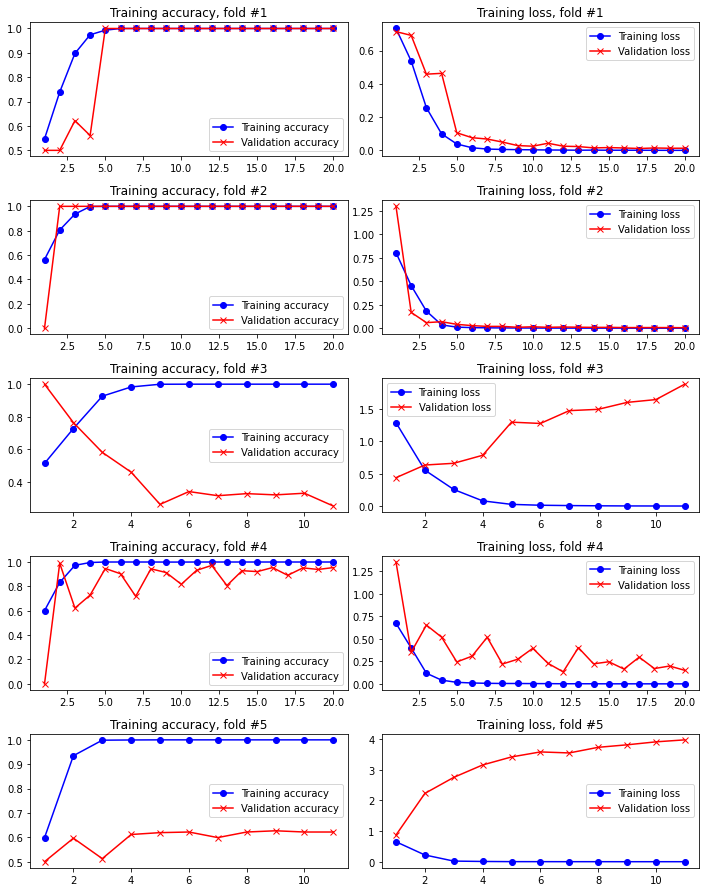

In [56]:
visualiseTrainingHistories(histories_dropouts)

As we can see on graphs above dropout layers helped a little bit in one fold (#4) that was overfitting but failed on the next 2 (#3 and #5). 

### Final model trained on a full training dataset

In [20]:
X_train, y_train = convertDatasetToArrays(df_train) 

reinitialiseModel(cnn_clf)

history = cnn_clf.fit(X_train, 
                      y_train, 
                    #   epochs=epochs_nb,
                      epochs=8,
                      batch_size=128,
                      )

Epoch 1/8
21/21 [==============================] - 1s 60ms/step - loss: 0.7397 - accuracy: 0.5041
Epoch 2/8
21/21 [==============================] - 1s 45ms/step - loss: 0.5827 - accuracy: 0.6931
Epoch 3/8
21/21 [==============================] - 1s 46ms/step - loss: 0.6524 - accuracy: 0.7157
Epoch 4/8
21/21 [==============================] - 1s 45ms/step - loss: 0.1899 - accuracy: 0.9649
Epoch 5/8
21/21 [==============================] - 1s 45ms/step - loss: 0.2201 - accuracy: 0.9075
Epoch 6/8
21/21 [==============================] - 1s 45ms/step - loss: 0.0815 - accuracy: 0.9793
Epoch 7/8
21/21 [==============================] - 1s 45ms/step - loss: 0.0183 - accuracy: 1.0000
Epoch 8/8
21/21 [==============================] - 1s 45ms/step - loss: 0.0101 - accuracy: 1.0000


### Test set evaluation

In [21]:
X_test, y_test, motorIds_test = convertDatasetToArrays(df_test, return_motorIds_array=True)

cnn_clf.evaluate(X_test, y_test)

62/62 [==============================] - 0s 7ms/step - loss: 0.1208 - accuracy: 0.9685


[0.12081621587276459, 0.9685279130935669]

In [22]:
preds_test = cnn_clf.predict(X_test)

preds_test_round = []
for pred in preds_test:
    pred_round = 1 if pred >= 0.5 else 0
    preds_test_round.append(pred_round)

In [23]:
results_table = countPredictionsByMotorId(y_test, preds_test_round, motorIds_test)
results_table.style.format({'good': '{:,.0f}',
                            'bad': '{:,.0f}',  
                            'prediction_confidence': '{:,.2%}'.format})

,good,bad,ground_truth,summed_prediction,prediction_confidence
motorId,,,,,
2,193,4,True,True,97.97%
7,197,0,True,True,100.00%
8,197,0,True,True,100.00%
14,0,197,False,False,100.00%
15,162,35,True,True,82.23%
16,0,197,False,False,100.00%
17,0,197,False,False,100.00%
19,0,197,False,False,100.00%
20,0,197,False,False,100.00%


In [24]:
final_accuracy = (results_table.ground_truth == results_table.summed_prediction).astype(int).sum() / len(results_table.ground_truth)
print(f"final accuracy: {final_accuracy*100 :.2f}%")

final accuracy: 100.00%


## Cross validation test for the final model

The dataset includes a really low number of motors (only 23), therefore the accuracy of the model and the quality of the training are highly influencedby the split of the dataset. To check if the final model keeps a good accuracy also for different dataset splits a kFold validation

In [25]:
def finalCrossValidationCNN(model,
                            dataset,
                            nb_test_motors=10,
                            iter_nb=1,
                            epochs=5,
                            callbacks=None,
                            batch_size=16):
    """ Function performs a final cross validation on the given model and full dataset, it does not include any validation during training 
        and calculates the accuracies with respect to whole data for the motor
    ---
    args:
        model:      model to be tested  -> keras.model
        df_train:   full dataset  -> d.DataFrame
        folds:      default=1, number of folds to be performed -> int
        epochs:     default=5,  number of training epochs -> int
        batch_size: defaulr=16, size of the training batch, should be power of 2 -> int
        shuffled_motor_list:    default=[], custom shuffled list of motors given by the user 
                                (can be used for tests or to reproduce the results from previous experiments)
                                If left empty, then the list of shuffled motors is generated by the function -> list
    ---
    returns:
        mean_accuracy:  mean mean absolute error of all the trainings
        accuracies:     all accuracies
    """ 
    if callbacks == None:
        callbacks = []
    nb_of_all_motors = len(dataset.motorId.unique())

    all_scores = []
    all_tables = []
    for i in range(iter_nb):
        # animate the fold counter
        sys.stdout.write('\r'+ f"fold: #{i+1}")
        # split train and test sets
        df_train, df_test, _ = splitTrainTestByMotorId(dataset,
                                                       nb_of_test_motors=nb_test_motors,
                                                       threshold=0.67)
        nb_val_motors = int(np.ceil(0.2*(nb_of_all_motors - nb_test_motors)))
        df_partial_train, df_val, _ = splitTrainTestByMotorId(dataset,
                                                              nb_of_test_motors=nb_val_motors,
                                                              threshold=0.7)
        X_train, y_train = convertDatasetToArrays(df_partial_train)
        X_val, y_val = convertDatasetToArrays(df_val)
        X_test, y_test, motorIds_test = convertDatasetToArrays(df_test, return_motorIds_array=True)
        
        # set a callback to save just the best model for each fold and add it to users callbacks list
        checkpoint_path = f'./cross_valid_temp_model/cross_valid_temp_model_f{i+1}'
        callbacks = callbacks + [keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                monitor="val_loss",
                                                                #  verbose=0,
                                                                save_best_only=True)]

        # reset model
        reinitialiseModel(model)

        history = model.fit(X_train, 
                            y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=[X_val, y_val],
                            callbacks=callbacks,
                            verbose=0
                            )

        # loading the best model
        reinitialiseModel(model)
        model.load_weights(checkpoint_path)

        # getting model Accuracy
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f'Test accuracy (general, NOT w.r.t. motors!): {test_accuracy}')

        # making predictions for current test subset
        preds = model.predict(X_test)
        preds_test_round = []
        for pred in preds:
            pred_round = 1 if pred >= 0.5 else 0
            preds_test_round.append(pred_round)
        # forming a count table for the results w.r.t. the motors
        results_table = countPredictionsByMotorId(y_test, preds_test_round, motorIds_test)
        all_tables.append(results_table)
        # calculating accuarcies for final full predictions w.r.t motor
        final_accuracy = (results_table.ground_truth == results_table.summed_prediction).astype(int).sum() / len(results_table.ground_truth)
        print(f"Test accuracy (W.R.T motors): {final_accuracy}")
        all_scores.append(final_accuracy)
    
    mean_accuracy = np.mean(all_scores)

    return mean_accuracy, all_scores, all_tables



In [26]:
callbacks = callbacks = [
                        keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                      patience=5, 
                                                      verbose=0)
                        ]

mean_accuracy, all_accuracies, all_tables = finalCrossValidationCNN(cnn_clf,
                                                                    df,
                                                                    iter_nb=15,
                                                                    nb_test_motors=10,
                                                                    epochs=20,
                                                                    callbacks=callbacks,
                                                                    batch_size=128)
clear_output()

In [27]:
all_accuracies

[0.9, 1.0, 1.0, 1.0, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [28]:
print(f'Minimal accuracy: {np.min(all_accuracies)}\nMaximal accuracy {np.max(all_accuracies)}')
print(f'Mean accuracy: {np.mean(all_accuracies) :.4f} \nVariance: {np.var(all_accuracies) :.6f}')

Minimal accuracy: 0.9
Maximal accuracy 1.0
Mean accuracy: 0.9800 
Variance: 0.001600


### Results of the splits with worst accuracies

In [32]:
all_tables[0]

,good,bad,ground_truth,summed_prediction,prediction_confidence
motorId,,,,,
2,0.0,197.0,True,False,1.000000
6,197.0,0.0,True,True,1.000000
8,197.0,0.0,True,True,1.000000
10,197.0,0.0,True,True,1.000000
13,0.0,197.0,False,False,1.000000
14,0.0,197.0,False,False,1.000000
18,0.0,197.0,False,False,1.000000
19,0.0,197.0,False,False,1.000000
20,0.0,197.0,False,False,1.000000


In [35]:
all_tables[4]

,good,bad,ground_truth,summed_prediction,prediction_confidence
motorId,,,,,
2,197.0,0.0,True,True,1.000000
4,197.0,0.0,True,True,1.000000
8,197.0,0.0,True,True,1.000000
10,197.0,0.0,True,True,1.000000
11,181.0,16.0,False,True,0.918782
19,0.0,197.0,False,False,1.000000
20,0.0,197.0,False,False,1.000000
21,90.0,107.0,False,False,0.543147
22,197.0,0.0,True,True,1.000000


In [34]:
all_tables[5]

,good,bad,ground_truth,summed_prediction,prediction_confidence
motorId,,,,,
2,197.0,0.0,True,True,1.0
3,197.0,0.0,True,True,1.0
7,197.0,0.0,True,True,1.0
8,197.0,0.0,True,True,1.0
12,197.0,0.0,False,True,1.0
14,0.0,197.0,False,False,1.0
16,0.0,197.0,False,False,1.0
18,0.0,197.0,False,False,1.0
21,0.0,197.0,False,False,1.0


## Training model full dataset and saving it

The cross validation proved that the model generalizes well on most of data splits, therefore we can assume that the model trained on full dataset will have even better accuracy in real life use. 

Model trained this way will be saved for further application in industry

In [36]:
X_train_full, y_train_full = convertDatasetToArrays(df)

reinitialiseModel(cnn_clf)

cnn_clf.fit(X_train_full,
            y_train_full,
            epochs=8,
            batch_size=128,
            )

cnn_clf.save("/content/drive/My Drive/motor_noise_classifier/motor_noise_clf")

Epoch 1/8
36/36 [==============================] - 2s 57ms/step - loss: 7.2548 - accuracy: 0.5312
Epoch 2/8
36/36 [==============================] - 2s 46ms/step - loss: 0.8540 - accuracy: 0.8780
Epoch 3/8
36/36 [==============================] - 2s 46ms/step - loss: 0.0301 - accuracy: 0.9923
Epoch 4/8
36/36 [==============================] - 2s 46ms/step - loss: 0.0053 - accuracy: 0.9989
Epoch 5/8
36/36 [==============================] - 2s 46ms/step - loss: 0.0032 - accuracy: 0.9987
Epoch 6/8
36/36 [==============================] - 2s 46ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 7/8
36/36 [==============================] - 2s 46ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 8/8
36/36 [==============================] - 2s 47ms/step - loss: 9.9274e-04 - accuracy: 1.0000
INFO:tensorflow:Assets written to: /content/drive/My Drive/motor_noise_classifier/motor_noise_clf/assets
